November - Depth slices of salinity anomaly.

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import colors

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

import warnings
warnings.filterwarnings("ignore")

In [3]:
def get_vars(dirname, depth_ind):
    fname = "1_MCKNZ_1h_20170101_20170120_*"
    y,x = slice(1,-1,None), slice(1,-1,None)
    
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    filesU = general_functions.get_files(dirname, fname, 'grid_U')
            
    with scDataset(filesT) as dsT, scDataset(filesU) as dsU:
        deptht = dsT.variables['deptht'][depth_ind]
        vosaline0 = dsT.variables['vosaline'][:, depth_ind, y, x]
        sozotaux = dsU.variables['sozotaux'][:,0,0] 
        
    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        tmask0 = dsM.variables['tmask'][0, depth_ind, y, x]
        
    tmask = np.tile(tmask0, (len(sozotaux),1, 1))  
    vosaline = np.ma.array(vosaline0, mask=1 - tmask)
    
    return vosaline, sozotaux, deptht

In [29]:
def get_1day_avg(vel, day_start, day_end):
    day = slice(day_start*24, day_end*24, None)
    vel_day = np.mean(vel[day, ...], axis=0)
    return vel_day

In [4]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/idealized/sbcana_forcings/agrif_wind_timestep/'

In [46]:
vosalineA, sozotaux, depthtA = get_vars(dirname, 7)
vosalineB, sozotaux, depthtB = get_vars(dirname, 9)
vosalineC, sozotaux, depthtC = get_vars(dirname, 11)

In [37]:
salt_anomA = vosalineA[:,...] - vosalineA[0,...]
salt_anomB = vosalineB[:,...] - vosalineB[0,...]
salt_anomC = vosalineC[:,...] - vosalineC[0,...]

In [38]:
xs = np.arange(salt_anomA.shape[-1])
ys = np.arange(salt_anomA.shape[-2])

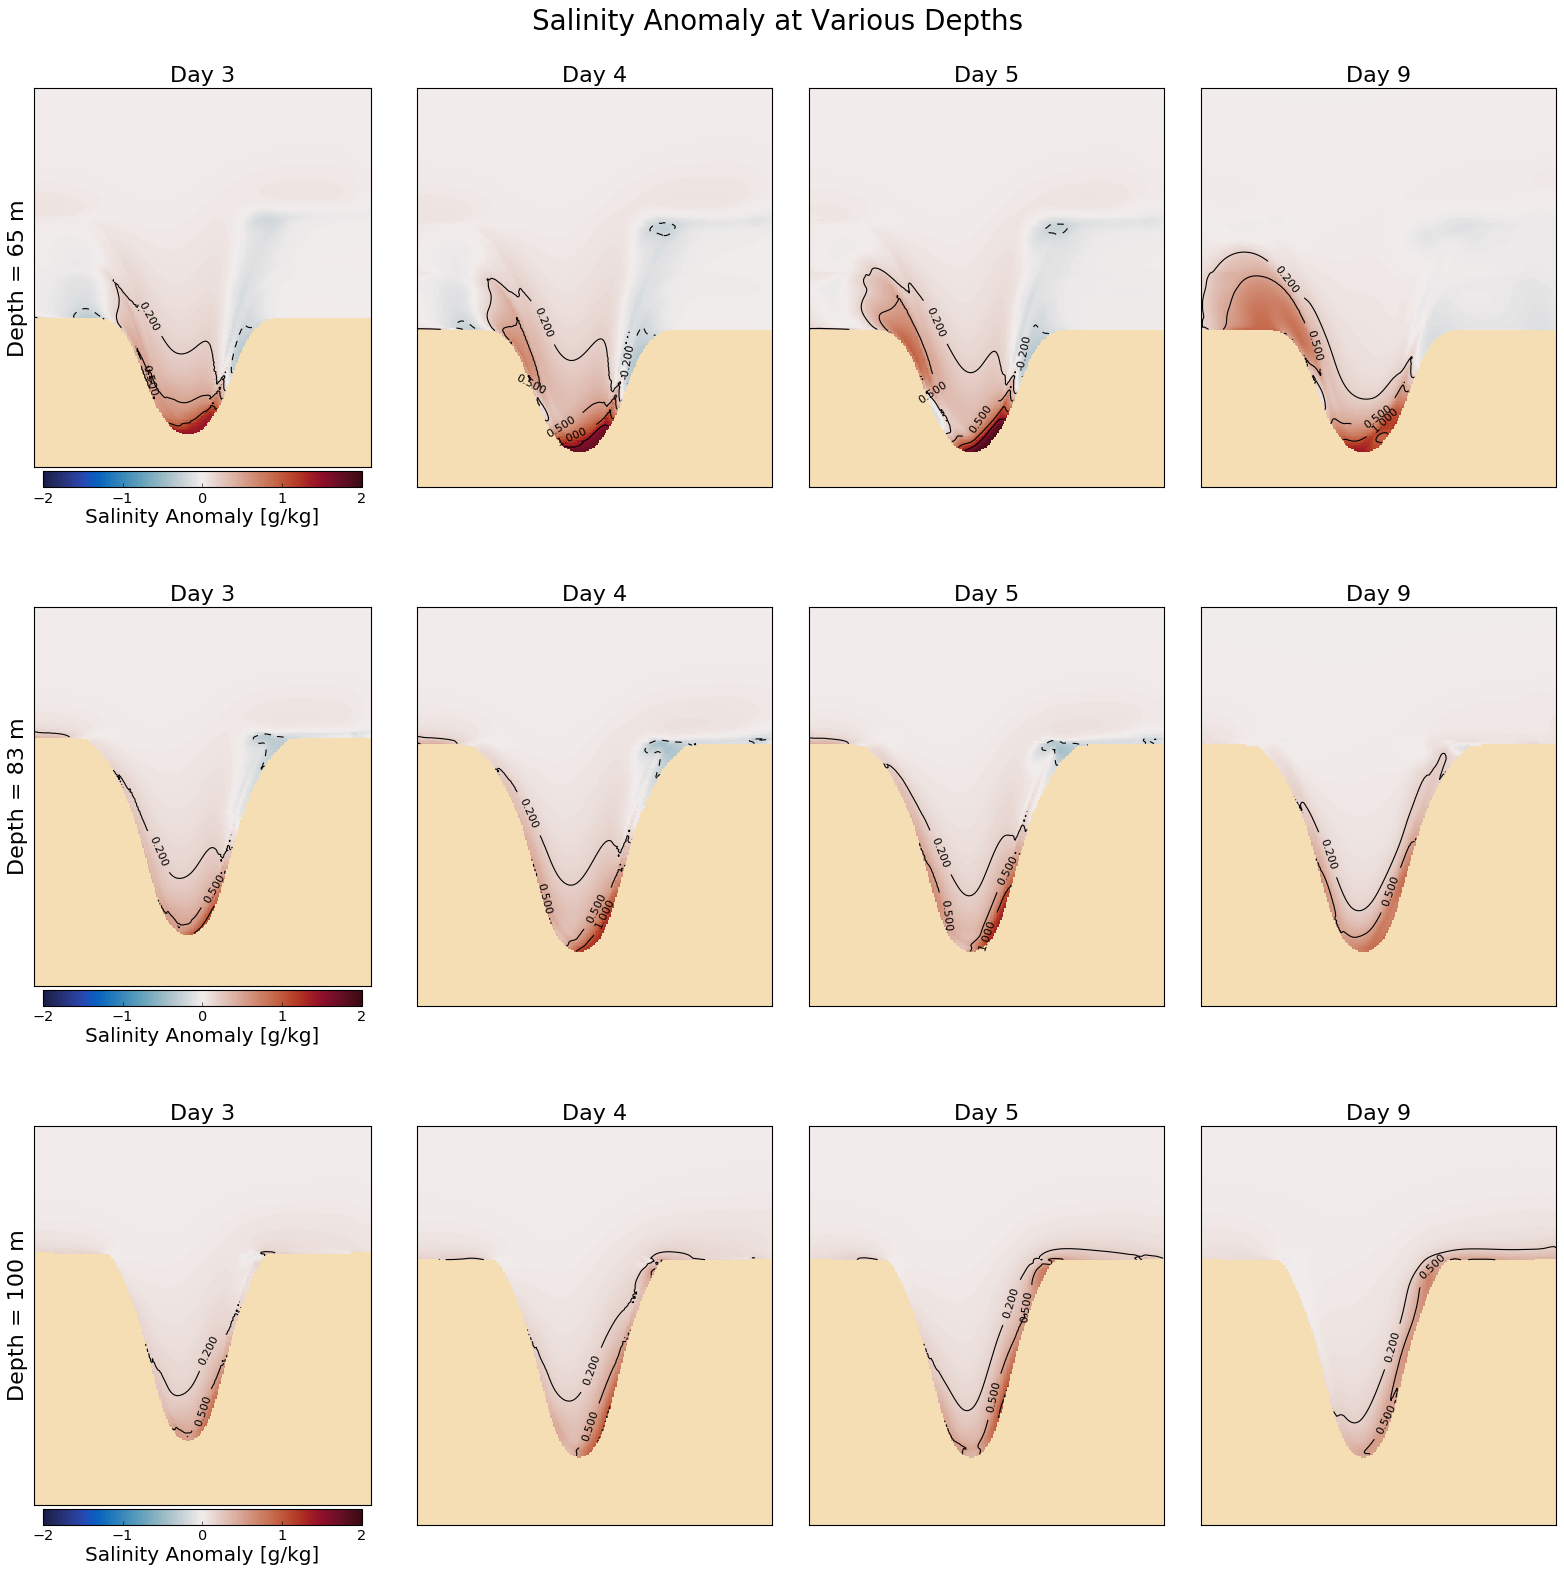

In [57]:
from matplotlib import ticker
cmap = plt.get_cmap(cmo.cm.balance)
cmap.set_bad('wheat')
fig, (axesA, axesB, axesC) = plt.subplots(3, 4, figsize=(20,20))

def plot_this(axes, vel_all, xs, ys, vm, deptht):
    levels = [-2, -1.5, -1, -0.5, -0.2, 0.2, 0.5, 1, 1.5, 2]
    for ax, day, n in zip(axes.flatten(), [2,3,4,8], np.arange(4)):
        vel_dayn = get_1day_avg(vel_all, day, day+1)
        p = ax.pcolormesh(xs, ys, vel_dayn, vmin=-1*vm, vmax=vm, cmap=cmap)
        cs = ax.contour(xs, ys, vel_dayn, levels = levels, colors='k')
        ax.clabel(cs, inline=1, fontsize=10)
        ax.set_aspect(aspect='equal')
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)
        ax.set_xlim([0, xs[-1]])
        ax.set_ylim([0, ys[-1]])
        ax.set_title('Day '+str(day+1), fontsize=20)
        if n==0:
            cbar = fig.colorbar(p, ax=ax, fraction=0.04, orientation='horizontal', pad=0.009)
            cbar.set_label('Salinity Anomaly [g/kg]', fontsize=18, rotation=0, labelpad=2.5)
            cbar.ax.tick_params(labelsize=13)
            tick_locator = ticker.MaxNLocator(nbins=5)
            cbar.locator = tick_locator
            cbar.update_ticks()
            ax.set_ylabel('Depth = '+str(int(deptht))+ ' m', fontsize=20)
    return

vm = 2
plot_this(axesA, salt_anomA, xs, ys, vm, depthtA)
plot_this(axesB, salt_anomB, xs, ys, vm, depthtB)
plot_this(axesC, salt_anomC, xs, ys, vm, depthtC)

fig.tight_layout(w_pad=1.2, h_pad=10)
fig.suptitle('Salinity Anomaly at Various Depths', fontsize=25)
plt.subplots_adjust(top=0.93)
fig.savefig('salinity_anomaly.png', dpi=fig.dpi)